In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# scaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
)

# Models
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Data

In [2]:
rumah123_df = pd.read_csv("../../data/rumah123_ready.csv")

### Splitting

In [3]:
X = rumah123_df.drop(columns=["price"])
y = rumah123_df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.index.size)
print(X_test.index.size)

15536
3885


In [4]:
rumah123_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19421 entries, 0 to 19420
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          19421 non-null  int64 
 1   bedroom        19421 non-null  int64 
 2   bathroom       19421 non-null  int64 
 3   land_area      19421 non-null  int64 
 4   building_area  19421 non-null  int64 
 5   location       19421 non-null  object
dtypes: int64(5), object(1)
memory usage: 910.5+ KB


### Target Encoding

In [5]:
# Inisialisasi dan fit TargetEncoder hanya pada train
encoder = TargetEncoder(cols=["location"])
encoder.fit(X_train, y_train)

# Transformasi train dan test
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

### Feature Scalling

In [6]:
# Inisiasi metode scalling
scalers = {
    "Standard": StandardScaler(),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler(),
    "MaxAbs": MaxAbsScaler(),
}

In [7]:
# evaluasi tiap scaler
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, scaler in scalers.items():
    pipeline = Pipeline(
        [("scaler", scaler), ("reg", RandomForestRegressor(random_state=42))]
    )
    scores = cross_val_score(
        pipeline, X_train_encoded, y_train, cv=cv, scoring="r2", n_jobs=-1
    )
    results.append(
        {"Scaler": name, "Mean R2": np.mean(scores), "Std Dev R2": np.std(scores)}
    )

In [8]:
# tampilkan hasil scalernya
scaler_results = (
    pd.DataFrame(results).sort_values("Mean R2", ascending=False).reset_index(drop=True)
)
scaler_results

,Scaler,Mean R2,Std Dev R2
0,MaxAbs,0.683220,0.005486
1,MinMax,0.682890,0.005777
2,Robust,0.682859,0.005491
3,Standard,0.682727,0.005816


In [9]:
# Normalisasi dengan MinMaxScaler
scaler_name = scaler_results.iloc[0]["Scaler"]
scaler = scalers[scaler_name]
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

### Modeling

In [10]:
# Inisialisasi model
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
}

In [11]:
# Evaluasi model
def model_selection_regression(X_train, X_test, y_train, y_test):
    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        results.append({"Model": name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2})

    results_df = pd.DataFrame(results)
    return results_df.sort_values(by="R²", ascending=False)

In [12]:
results = model_selection_regression(X_train_scaled, X_test_scaled, y_train, y_test)
results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 15536, number of used features: 5
[LightGBM] [Info] Start training from score 1117.923790


,Model,MAE,MSE,RMSE,R²
2,XGBoost,202.041343,71090.698398,266.628390,0.704503
4,CatBoost,207.003023,72925.036326,270.046360,0.696878
0,Random Forest,200.054388,73423.523979,270.967755,0.694806
3,LightGBM,209.178399,74138.239566,272.283381,0.691835
1,Extra Trees,202.986785,78536.983352,280.244506,0.673551


In [13]:
def plot_best_model_reg(X_train, X_test, y_train, y_test):

    # Ambil model terbaik
    best_model_name = results.iloc[0]["Model"]
    best_model = models[best_model_name]

    # Fit dan prediksi
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        "r--",
        lw=2,
        label="Perfect Prediction",
    )
    plt.xlabel("Aktual")
    plt.ylabel("Prediksi")
    plt.title(f"Perbandingan Aktual vs Prediksi (Model Terbaik: {best_model_name})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

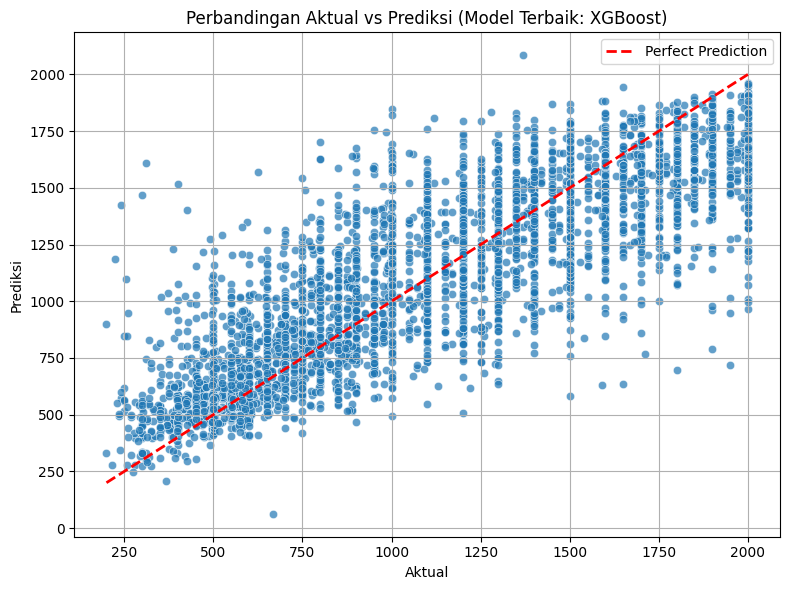

In [14]:
plot_best_model_reg(X_train_scaled, X_test_scaled, y_train, y_test)